# Tutorial 2: Splicing MPRA analysis using multiple built-in G-P maps

In [36]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Special imports
import mavenn
import seaborn as sns

In [2]:
# This should be moved to mavenn
from tmp import split_dataset
mavenn.split_dataset = split_dataset

Here we show how to train and visualize the `'mpsa_additive_ge'`, `'mpsa_neighbor_ge'`,`'mpsa_pairwise_ge'`,  and `'mpsa_blackbox_ge'` models, which are featured in Fig. 5 of Tareen et al. (2021). All four of these models are  trained on the `'mpsa'` dataset provided with MAVE-NN, which was collected as part of the DMS study of Wong et al. (2018).

## Training

First we load, split, and preview the built-in `'mpsa'` dataset. We also compute the length of sequences in this dataset, as we will need this quantity for defining the architecture of our model.

In [11]:
# Load amyloid dataset
data_df = mavenn.load_example_dataset('mpsa')

# Get and report sequence length
L = len(data_df.loc[0,'x'])
print(f'Sequence length: {L:d} RNA nucleotides')

# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)

# Show dataset sizes
print(f'Train + val set size : {len(trainval_df):6,d} observations')
print(f'Test set size        : {len(test_df):6,d} observations')

# Preview trainval_df
trainval_df

Sequence length: 9 RNA nucleotides
Train + val set size : 24,405 observations
Test set size        :  6,078 observations


,validation,tot_ct,ex_ct,y,x
0,False,28,2,0.023406,GGAGUGAUG
1,False,193,15,-0.074999,UUCGCGCCA
2,False,27,0,-0.438475,UAAGCUUUU
3,False,130,2,-0.631467,AUGGUCGGG
4,False,552,19,-0.433012,AGGGCAGGA
...,...,...,...,...,...
24400,False,167,1467,1.950100,GAGGUAAAU
24401,False,682,17,-0.570465,AUCGCUAGA
24402,False,190,17,-0.017078,CUGGUUGCA
24403,False,154,10,-0.140256,CGCGCACAA


Next we train our models. In order to train multiple models of multiple different `gpmap_type` on the same dataset using similar hyperparameters, we use dictionaries to specify default keyword arguments for `model.Model()`  and `model.fit()`. We then loop over the different values for `gpmap_type`, modify the hyperparameter dictionary as desired, then instantiate the model, set its training data, fit its parameters, evaluate its prerformance, and save it.

In [15]:
# Set default keyword arguments for model.Model()
default_model_kwargs = {
    'L':L,
    'alphabet':'rna',
    'regression_type':'GE',
    'ge_noise_model_type':'SkewedT',
    'ge_heteroskedasticity_order':2
}

# Set default keyword arguments for model.fit()
default_fit_kwargs = {
    'learning_rate':.001,
    'epochs':500,
    'batch_size':200,
    'early_stopping':True,
    'early_stopping_patience':30,
    'linear_initialization':False
}

# Iterate over types of G-P maps
gpmap_types = ['additive','neighbor','pairwise','blackbox']
print(f'Training {len(gpmap_types)} models: {gpmap_types}')
for gpmap_type in gpmap_types:

    # Set model name
    model_name = f'mpsa_{gpmap_type}_ge'
    print('-----------------------------')
    print(f"Training '{model_name}' model...\n")

    # Copy keyword arguments
    model_kwargs = default_model_kwargs.copy()
    fit_kwargs = default_fit_kwargs.copy()

    # Modify keyword arguments based on model being fit
    if gpmap_type=='additive': pass;
    elif gpmap_type=='neighbor': pass;
    elif gpmap_type=='pairwise':
        fit_kwargs['batch_size'] = 50
    elif gpmap_type=='blackbox':
        model_kwargs['gpmap_kwargs'] = {'hidden_layer_sizes':[10]*5,
                                        'features':'pairwise'}
        fit_kwargs['learning_rate'] = 0.0005
        fit_kwargs['batch_size'] = 50
        fit_kwargs['early_stopping_patience'] = 10

    # Define model
    model = mavenn.Model(gpmap_type=gpmap_type, **model_kwargs)

    # Set training data
    model.set_data(x=trainval_df['x'],
                   y=trainval_df['y'],
                   validation_flags=trainval_df['validation'])

    # Fit model to data
    model.fit(**fit_kwargs)

    # Compute variational information on test data
    I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
    print(f'test_I_var: {I_var:.3f} +- {dI_var:.3f} bits')

    # Compute predictive information on test data
    I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
    print(f'test_I_pred: {I_pred:.3f} +- {dI_pred:.3f} bits')

    # Save model to file
    model.save(model_name)

print('Done!')

Training 4 models: ['additive', 'neighbor', 'pairwise', 'blackbox']
-----------------------------
Training 'mpsa_additive_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.228 sec.


0epoch [00:00, ?epoch/s]

test_I_var: 0.204 +- 0.028 bits
test_I_pred: 0.223 +- 0.014 bits
Model saved to these files:
	mpsa_additive_ge.pickle
	mpsa_additive_ge.h5
-----------------------------
Training 'mpsa_neighbor_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.258 sec.


0epoch [00:00, ?epoch/s]

test_I_var: 0.292 +- 0.024 bits
test_I_pred: 0.320 +- 0.014 bits
Model saved to these files:
	mpsa_neighbor_ge.pickle
	mpsa_neighbor_ge.h5
-----------------------------
Training 'mpsa_pairwise_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.229 sec.


0epoch [00:00, ?epoch/s]

test_I_var: 0.333 +- 0.025 bits
test_I_pred: 0.336 +- 0.018 bits
Model saved to these files:
	mpsa_pairwise_ge.pickle
	mpsa_pairwise_ge.h5
-----------------------------
Training 'mpsa_blackbox_ge' model...

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.223 sec.


0epoch [00:00, ?epoch/s]

test_I_var: 0.366 +- 0.027 bits
test_I_pred: 0.442 +- 0.016 bits
Model saved to these files:
	mpsa_blackbox_ge.pickle
	mpsa_blackbox_ge.h5
Done!


## Visualization

To compare these models side-by-side, we first load them into a dictionary:

In [21]:
# Create list of model names
model_names = [f'mpsa_{gpmap_type}_ge' for gpmap_type in gpmap_types]

# Load models into a dictionary indexed by model name
model_dict = {name:mavenn.load(name) for name in model_names}

Model loaded from these files:
	mpsa_additive_ge.pickle
	mpsa_additive_ge.h5
Model loaded from these files:
	mpsa_neighbor_ge.pickle
	mpsa_neighbor_ge.h5
Model loaded from these files:
	mpsa_pairwise_ge.pickle
	mpsa_pairwise_ge.h5
Model loaded from these files:
	mpsa_blackbox_ge.pickle
	mpsa_blackbox_ge.h5


To compare the performance of these models, we plot variational and predictive
information in the form of a bar chart similar to that shown in Fig. 5a of
Tareen et al., (2021)

               name     gpmap  metric         I        dI
0  mpsa_additive_ge  additive   I_var  0.206685  0.027449
1  mpsa_additive_ge  additive  I_pred  0.222492  0.010370
2  mpsa_neighbor_ge  neighbor   I_var  0.304009  0.024735
3  mpsa_neighbor_ge  neighbor  I_pred  0.328629  0.013721
4  mpsa_pairwise_ge  pairwise   I_var  0.341770  0.025117
5  mpsa_pairwise_ge  pairwise  I_pred  0.341157  0.016300
6  mpsa_blackbox_ge  blackbox   I_var  0.372361  0.027256
7  mpsa_blackbox_ge  blackbox  I_pred  0.426555  0.014551


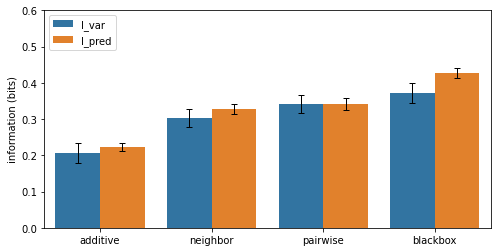

In [48]:
# Fill out dataframe containing values to plot
info_df = pd.DataFrame(columns=['name', 'gpmap', 'metric', 'I', 'dI'])
for gpmap_type in gpmap_types:

    # Get model
    name = f'mpsa_{gpmap_type}_ge'
    model = model_dict[name]

    # Compute variational information on test data
    I_var, dI_var =  model.I_variational(x=test_df['x'], y=test_df['y'])
    row = {'name':name,
           'gpmap':gpmap_type,
           'metric':'I_var',
           'I':I_var,
           'dI':dI_var}
    info_df = info_df.append(row, ignore_index=True)

    # Compute predictive information on test data
    I_pred, dI_pred = model.I_predictive(x=test_df['x'], y=test_df['y'])
    row = {'name':name,
           'gpmap':gpmap_type,
           'metric':'I_pred',
           'I':I_pred,
           'dI':dI_pred}
    info_df = info_df.append(row, ignore_index=True)

# Print dataframe
print(info_df)

# Create figure
fig, ax = plt.subplots(figsize=[8, 4])

# Plot bars
sns.barplot(ax=ax,
            data=info_df,
            hue='metric',
            x='gpmap',
            y='I')

# Plot errorbars
x = np.array([[x-.2,x+.2] for x in range(4)]).ravel()
ax.errorbar(x=x,
            y=info_df['I'].values,
            yerr=info_df['dI'].values,
            color='k', capsize=3, linestyle='none',
            elinewidth=1, capthick=1, solid_capstyle='round')

ax.set_ylabel('information (bits)')
ax.set_xlabel('')
ax.set_xlim([-.5, 3.5])
ax.set_ylim([0, 0.6])
ax.legend(loc='upper left')

It can also be useful to observe the training history of each model.

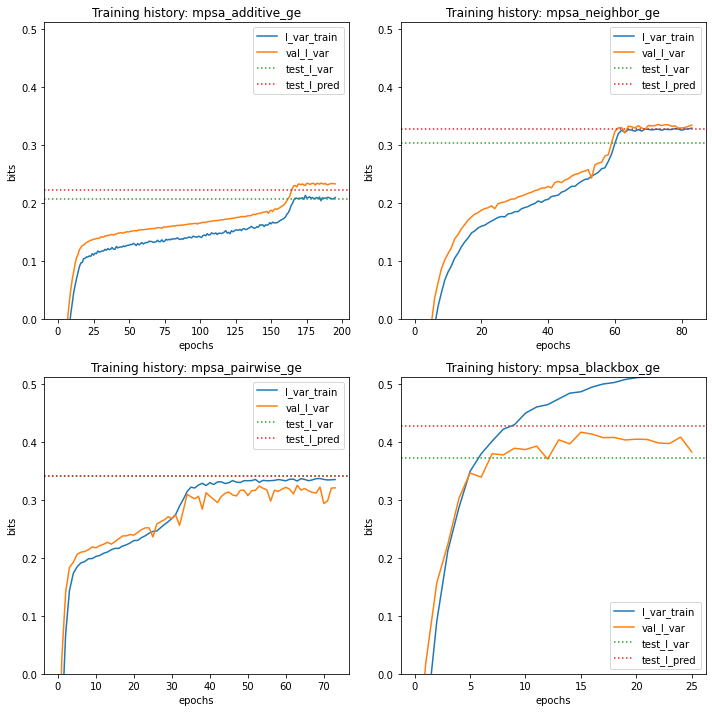

In [49]:
# Create figure and axes for plotting
fig, axs = plt.subplots(2,2,figsize=[10,10])
axs = axs.ravel()

# Loop over models
for ax, name in zip(axs, model_names):

    # Get model
    model = model_dict[name]

    # Plot I_var_train, the variational information on training data as a function of epoch
    ax.plot(model.history['I_var'],
            label=r'I_var_train')

    # Plot I_var_val, the variational information on validation data as a function of epoch
    ax.plot(model.history['val_I_var'],
            label=r'val_I_var')

    # Get part of info_df referring to this model and index by metric
    ix = (info_df['name']==name)
    sub_df = info_df[ix].set_index('metric')

    # Show I_var_test, the variational information of the final model on test data
    ax.axhline(sub_df.loc['I_var','I'], color='C2', linestyle=':',
               label=r'test_I_var')

    # Show I_pred_test, the predictive information of the final model on test data
    ax.axhline(sub_df.loc['I_pred','I'], color='C3', linestyle=':',
               label=r'test_I_pred')

    # Style plot
    ax.set_xlabel('epochs')
    ax.set_ylabel('bits')
    ax.set_title(f'Training history: {name}')
    ax.set_ylim([0, 1.2*I_pred])
    ax.legend()

# Clean up figure
fig.tight_layout()



Next we visualize the GE measurement process inferred as part of our each
latent phenotype model, comparing it to the test data. Note that the
measurement processes for all of the linear models (`'additive'`, `'neighbor'`,
`'pairwise'`) are similar, while that of the `'blackbox'` model is quite
different. This stark difference is due to the presence of nonlinearities in
in the `'blackbox'` model that are not present in the other three. It is not,
in general, useful to interpret

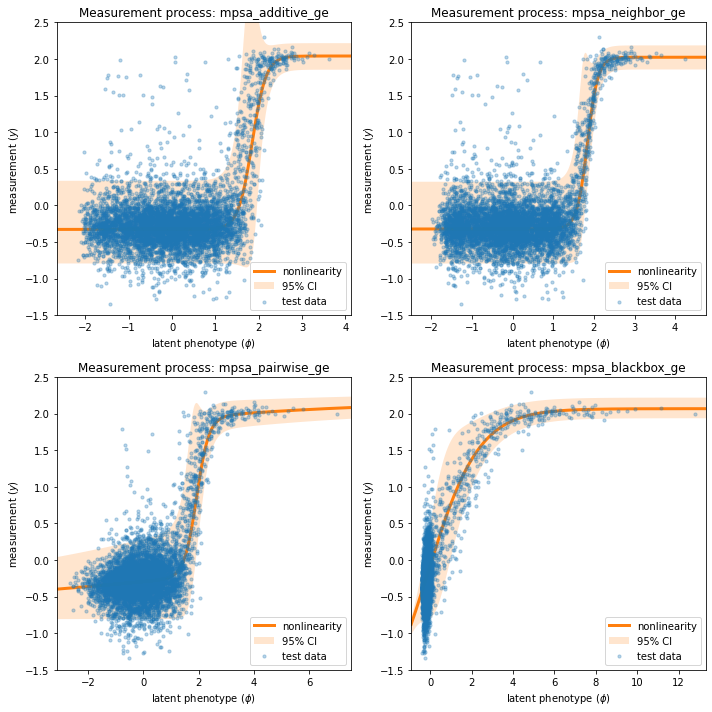

In [53]:
# Create figure and axes for plotting
fig, axs = plt.subplots(2,2,figsize=[10,10])
axs = axs.ravel()

# Loop over models
for ax, name in zip(axs, model_names):

    # Get model
    model = model_dict[name]

    # Get test data y values
    y_test = test_df['y']

    # Compute φ on test data
    phi_test = model.x_to_phi(test_df['x'])

    ## Set phi lims and create a grid in phi space
    phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

    # Compute yhat each phi gridpoint
    yhat_grid = model.phi_to_yhat(phi_grid)

    # Compute 95% CI for each yhat
    q = [0.025, 0.975]
    yqs_grid = model.yhat_to_yq(yhat_grid, q=q)


    # Plote 95% confidence interval
    ax.fill_between(phi_grid, yqs_grid[:, 0], yqs_grid[:, 1],
                    alpha=0.2, color='C1', lw=0, label='95% CI')

    # Plot GE nonlinearity
    ax.plot(phi_grid, yhat_grid,
            linewidth=3, color='C1', label='nonlinearity')

    # Plot scatter of φ and y values.
    ax.scatter(phi_test, y_test,
               color='C0', s=10, alpha=.3, label='test data', zorder=+100)

    # Style plot
    ax.set_xlim(phi_lim)
    ax.set_xlabel('latent phenotype ($\phi$)')
    ax.set_ylim([-1.5,2.5])
    ax.set_ylabel('measurement ($y$)')
    ax.set_title(f'Measurement process: {name}')
    ax.legend(loc='lower right')

fig.tight_layout()

To retrieve the values of our model's G-P map parameters, we use the mmethod `model.get_theta()`. This returns a dictionary:

In [14]:
# Retrieve G-P map parameter dict and view dict keys
theta_dict = model.get_theta(gauge='consensus')
theta_dict.keys()

dict_keys(['L', 'C', 'alphabet', 'theta_0', 'theta_lc', 'theta_lclc', 'theta_mlp', 'logomaker_df'])

It is important to appreciate that G-P maps usually have many non-identifiable directions in parameter space. These are called "gauge freedoms".  Interpreting the values of model parameters requires that we first "pin down" these gauge freedoms by using a clearly specified convension. Specifying `gauge='consensus'` in `model.get_theta()` accomplishes this fixing all the $\theta_{l:c}$ parameters that contribute to the consensus sequence to zero. This convension allows all the other $\theta_{l:c}$ parameters in the additive model to be interpreted as single-mutation effects $\Delta \phi$ away from the consensus sequence.

Finally, we use `mavenn.heatmap()` to visualize these additive parameters. This function takes a number of keyword arguments, which we summarize here. More information can be found in this function's docstring.

- `ax=ax`: specifies the axes on which to draw both the heatmap and the colorbar.
- `values=theta_dict['theta_lc']`: specifies the additive parameters in the form of a `np.array` of size `L`x`C`, where `C` is the alphabet size.
- `alphabet=theta_dict['alphabet']`: provides a list of characters corresponding to the columns of `values`.
- `seq=model.x_stats['consensus_seq']`: causes `mavenn.heatmap()` to highlight the characters of a specific sequence of interest. In our case this is the consensus sequence, the additive parameters for which are all fixed to zero.
- `seq_kwargs={'c':'gray', 's':25}`: provides a keyword dictionary to pass to `ax.scatter()`; this specifies how the characters of the sequence of interest are to be graphically indicated.
- `cmap='coolwarm'`: specifies the colormap used to represent the values of the additive parameters.
- `cbar=True`: specifies that a colorbar be drawn
- `cmap_size='2%'`: specifies the width of the colorbar relative to the enclosing ax object.
- `cmap_pad=.3`: specifies the spacing between the heatmap and the colorbar
- `ccenter=0`: centers the colormap at zero.

This function returns two objects:
- `heatmap_ax` is the axes object on which the heatmap is drawn.
- `cb` is the colorbar object; it's corresponding axes is given by `cb.ax`.

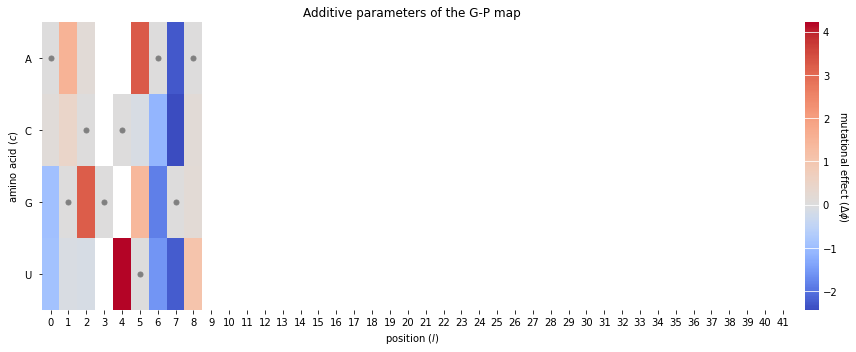

In [15]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(12,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta_dict['theta_lc'],
                                alphabet=theta_dict['alphabet'],
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap
heatmap_ax.set_xticks(np.arange(0,42))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(r'Additive parameters of the G-P map')

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)

Note that many of the squares in the heatmap are white. These correspond to additive parameters whose values are `NaN`. MAVE-NN sets the values of a feature effect to `NaN` when no variant in the training set exhibits that feature. Such `NaN` parameters are common, even among additive parameters, as DMS libraries often do not contain a comprehensive set of single-amino-acid mutations.

## References

1. Tareen, A., Posfai, A., Ireland, W. T., McCandlish, D. M. & Kinney, J. B. MAVE-NN: learning genotype-phenotype maps from multiplex assays of variant effect. bioRxiv doi:10.1101/2020.07.14.201475 (2020).
1. Seuma, M., Faure, A., Badia, M., Lehner, B. & Bolognesi, B. The genetic landscape for amyloid beta fibril nucleation accurately discriminates familial Alzheimer’s disease mutations. eLife 10, e63364 (2021).

